In [1]:
#!pip install networkx
#!pip install peartree
#!pip install osmnx
#!pip install numpy 
#!pip install random
#!pip install folium==0.11.0
#!pip install imgkit==1.0.2
#!pip install selenium==3.141.0

#pip install networkx peartree osmnx numpy folium==0.11.0 imgkit==1.0.2 selenium

In [2]:
from collections import defaultdict, OrderedDict, Counter
import networkx as nx
import numpy as np
import peartree as pt
import random
import torch
import torch_geometric
import torch_geometric.utils as pyg
import numpy as np
import folium as fm
import osmnx as ox
import partridge as ptg
import pandas as pd
from torch_geometric.data import Data

############### MY MODULES ###############
import sim
from sensor import *
from scenerio import *
from dsp_memo import DspMemo

In [3]:
############ GLOBAL VARIABLES #############

def reset_network():
    global_variables = {
        'time_table': None,
        'feed': None,
        'G': None,
        'stop_times': None,
        'routes': None,
        'trips': None,
        'all_routes': None,
        'all_trips': None,

        'stop_times_dict': None,
        'trips_per_stop': None,
        'routes_per_stop': None,
        'stop_ranks': None,
        'route_subgraphs': None,
        'edge_departures': None,
        'trip_subgraphs': None,
        'stops_per_trip': None,
        'dsp_memo':None
    }
    
    globals().update(global_variables)
    
def reset_sim():
    global_variables = {
        'error': 0,
        'routes_per_gateway': None,
        'gateways_per_route': None,
        'all_gateways': None,
        'all_sensors': None,
        'sensor_count': None,
        'sensor_objects': None,
    }

    globals().update(global_variables)

In [4]:
################## HELPER FUNCTIONS ##################

def get_stopid(node_name):
    return node_name.split('_')[-1]


def namify_stop(g_name,stop_id):
    return "{0}_{1}".format(g_name,stop_id)


def invert_dict(d):
    inverted_d = defaultdict(set)
    for k in d.keys():
        for v in d[k]:
            inverted_d[v].add(k)
    return inverted_d

# I don't think this is useful
def get_routes_per_stop_id(stop_id):
    for stop_id in time_table.stop_id.unique():
            routes = time_table[time_table.stop_id == stop_id].route_id.unique()
            return set(routes)


def get_time_to_next_departure(current_time, departure_list):
    try:
        next_departure = min(v for v in departure_list if v >= current_time)
        wait_time = next_departure - current_time
    except:
        wait_time = None

    return wait_time

In [5]:
def load_network():
    global feed,G,dsp_memo

    feed = pt.get_representative_feed('data/gtfs/' + sim.network_file)
    G = pt.load_feed_as_graph(feed, sim.start, sim.end, interpolate_times=True)
    dsp_memo = DspMemo()
    
def load_stop_times():
    global stop_times, routes, trips, time_table


    stop_times = feed.stop_times
    routes = feed.routes
    trips = feed.trips

    stoptimes_trips = stop_times.merge(trips, left_on='trip_id', right_on='trip_id')
    stoptimes_trips_routes = stoptimes_trips.merge(routes, left_on='route_id', right_on='route_id')

    columns = ['route_id',
               'service_id',
               'trip_id',
               #'trip_headsign',
               'direction_id',
               #'block_id',
               #'shape_id',
               #'route_short_name',
               #'route_long_name',
               'route_type',
               'arrival_time',
               'departure_time',
               'stop_id',
               'stop_sequence'
              ]

    time_table = stoptimes_trips_routes[columns]

def format_stop_times():
    global time_table, all_trips, all_routes

    #time_table = pt.summarizer._trim_stop_times_by_timeframe(time_table, sim.start, sim.end)

    time_table = time_table[~time_table['route_id'].isnull()]

    time_table = pt.summarizer._linearly_interpolate_infill_times(
        time_table,
        use_multiprocessing=False)

    if 'direction_id' in time_table:
        # If there is such column then check if it contains NaN
        has_nan = time_table['direction_id'].isnull()
        if sum(has_nan) > 0:
            # If it has no full coverage in direction_id, drop the column
            time_table.drop('direction_id', axis=1, inplace=True)

    # all_routes = set(feed.routes.route_id.values)
    all_routes = set(time_table.route_id.unique())
    all_trips = set(time_table.trip_id.unique())



def analyze_stops():
    global stop_times_dict, trips_per_stop, routes_per_stop, stop_ranks
    stop_times_dict = defaultdict(dict)
    trips_per_stop = defaultdict(set)
    routes_per_stop = defaultdict(set)
    routes_per_stop = defaultdict(set)
    stop_ranks = OrderedDict()

    for i,row in time_table.iterrows():
       trips_per_stop[row.stop_id].add(row.trip_id)
       routes_per_stop[row.stop_id].add(row.route_id)

    d = {}
    for k,v in routes_per_stop.items():
        d[k] = len(v)

    for k in sorted(d, key=d.get, reverse=True):
        stop_ranks[k] = d[k]
    #stop_ranks = {k:d[k] for k in sorted(d, key=d.get, reverse=True)} 
    
def assign_gateways_to_nodes():
    global all_gateways #input
    global G #output

    attr = {gw:True for gw in all_gateways}
    nx.set_node_attributes(G, name='is_gateway', values=attr)

    return G




In [6]:
#### Add departure times of source node to edges
def get_departure_times_per_edge_per_route():
    import pandas as pd

    global time_table  # input
    global edge_departures  # output

    has_dir_col = 'direction_id' in time_table.columns.values

    all_deps = []
    all_route_ids = []
    all_trip_ids = []
    all_from_stop_ids = []
    all_to_stop_ids = []

    for trip_id in time_table.trip_id.unique():

        tst_sub = time_table[time_table.trip_id == trip_id]
        route = tst_sub.route_id.values[0]

        # Just in case both directions are under the same trip id
        for direction in [0, 1]:
            # Support situations where direction_id is absent from the
            # GTFS data. In such situations, include all trip and stop
            # time data, instead of trying to split on that column
            # (since it would not exist).
            if has_dir_col:
                dir_mask = (tst_sub.direction_id == direction)
                tst_sub_dir = tst_sub[dir_mask]
            else:
                tst_sub_dir = tst_sub.copy()

            tst_sub_dir = tst_sub_dir.sort_values('stop_sequence')
            
            deps = tst_sub_dir.departure_time[:-1]

            # Add each resulting list to the running array totals
            all_deps += list(deps)

            from_ids = tst_sub_dir.stop_id[:-1].values
            all_from_stop_ids += list(from_ids)

            to_ids = tst_sub_dir.stop_id[1:].values
            all_to_stop_ids += list(to_ids)

            all_route_ids.extend([route] * len(deps))
            all_trip_ids.extend([trip_id] * len(deps))

    # Only return a dataframe if there is contents to populate
    # it with
    if len(all_deps) > 0:
        # Now place results in data frame
        edge_departures = pd.DataFrame({
            'from_stop_id': all_from_stop_ids,
            'to_stop_id': all_to_stop_ids,
            'departure_times': all_deps,
            'route_id': all_route_ids,
            'trip_id': all_trip_ids})

        
def add_departure_to_edge():
    global edge_departures  # input
    global G  # output

    for i, row in edge_departures.drop_duplicates(['from_stop_id', 'to_stop_id']).iterrows():
        u,v = row.from_stop_id, row.to_stop_id

        dep_mask = (edge_departures['from_stop_id'] == u) & (edge_departures['to_stop_id'] == v)
        #dep_list = edge_deps[dep_mask].deps.values
        dep_list = edge_departures[dep_mask][['route_id', 'departure_times']].sort_values(['departure_times'])

        dep_per_route = dep_list.groupby('route_id')['departure_times'].apply(lambda x: x.tolist()).to_dict(into=OrderedDict)

        u,v =  namify_stop(G.name,u), namify_stop(G.name,v)

        #TODO:: find out why you have to do this
        if u in G and v in G[u]:
            G[u][v][0]['departure_time'] = dep_per_route


    #test to make sure all edges is serviced
    for x in G.edges(keys=True,data=True):
        if 'departure_time' not in x[3]:
            print(x)

In [7]:
## Randomly selects stops to serve as sensors
def randomly_select_sensor_locations():
    global G # input
    global all_sensors, sensor_count # output


    all_stops = set(G.nodes)
    sensor_count = round(len(all_stops) * sim.pct_stops_as_sensors / 100)

    eligible_stops = list(all_stops - set(all_gateways)) #remove gateways from the list
    all_sensors = np.random.choice(eligible_stops, size=sensor_count, replace=False)


## Mark selected nodes as sensors
def assign_sensors_to_nodes():
    global all_sensors  # input
    global G  # output

    attr = {sensor:True for sensor in all_sensors}

    nx.set_node_attributes(G, name='is_sensor', values=attr)


def generate_sensors():
    global all_sensors, routes_per_stop # input
    global sensor_objects # output

    sensor_objects = {}

    msg_gen_rate = np.random.randint(low = sim.msg_gen_rate_range[0], high= sim.msg_gen_rate_range[1], size=len(all_sensors)) # 10mins to 12 hours
    start_time = np.random.randint(low = sim.msg_gen_rate_range[0], high=sim.msg_gen_rate_range[1], size=len(all_sensors)) # 0 to 1 hour
    np.random.shuffle(start_time)

    print(sum(msg_gen_rate), sum(start_time))

    #exit()


    for i,sensor_name in enumerate(all_sensors):
        #print(i,sensor_name)
        #r = get_routes_per_stop_id(get_stopid(sensor_name))
        r = routes_per_stop[get_stopid(sensor_name)]

        s = OnRouteSensor(name=sensor_name, routes=r, start_time=start_time[i], msg_gen_rate=msg_gen_rate[i], msg_ttl=None, data_size=None)
        sensor_objects[sensor_name]=s


def generate_route_subgraphs():
    global G, routes_per_stop, all_routes # input
    global route_subgraphs, stops_per_route # output

    route_subgraphs = {}
    stops_per_route = invert_dict(routes_per_stop)

    for r in all_routes:
        sub_nodes = [namify_stop(G.name, s) for s in stops_per_route[r]]
        # G.remove_nodes_from([n for n in G if n not in set(nodes)])
        sub_graph = G.subgraph(sub_nodes).copy()
        route_subgraphs[r] = sub_graph



def calculate_delay(routes, sensor, time):
    """
    find shortest path from sensor node to a gateway node in the graph, weight is edge cost,
    while factoring in duration from current time to next next dept time for that edge.

    save gen_time and latency to sensor object

    remember departure time, distance is in seconds
    while "time", gen_time,start_time is in minutes.
    so remember to convert it.
    """
    global G, route_subgraphs, gateways_per_route, dsp_memo  # inputs

    global error

    import sys
    waiting_time = None
    shortest_distance, shortest_path = sys.float_info.max, None  # to any gateway


    for r in routes:
        for gateway in gateways_per_route[r]:

            g = route_subgraphs[r].copy()

            wait_time = None

            try:
                distance, path = dsp_memo.getDsp(g, r, sensor.name, namify_stop(G.name, gateway))
#                 distance, path = nx.single_source_dijkstra(g, sensor.name, namify_stop(G.name, gateway), weight='length')
            except Exception as e:
                continue

            while len(path) > 1:
                '''
                make sure then you limit duration to 24 hours. later if time is greater than 24
                message is not delivered
                '''

                # TODO:: error rate too high.. fix it.
                #print(path)
                departure_list = g[sensor.name][path[1]][0]['departure_time'].get(r, None)

                #print(departure_list)
                if departure_list == None:
                    # print("no departure time found")
                    break
                    #g.remove_node(path[1])
                    #continue

                else:
                    wait_time = get_time_to_next_departure(current_time=time, departure_list=departure_list)
                    break


            if wait_time != None:

                if distance + wait_time < shortest_distance:
                    shortest_distance, shortest_path = distance + wait_time, path
                    waiting_time = wait_time
                    #break

    if waiting_time == None:
        shortest_distance = None
        error +=1


    sensor.gen_times.append(time)  # in sec
    sensor.msg_latencies.append(shortest_distance)  # in sec
    sensor.waiting_time.append(waiting_time)
    sensor.hops.append(shortest_path)



def store_results():
    import json
    from collections import defaultdict
    final_result = defaultdict(list)

    final_result['sim_time'] = sim.duration

    # print(sensor_objects.values())
    # type(sensor_objects.values()[0])

    for s in sensor_objects.values():

        data = {
            'delivery_rate': None,
            'no_of_routes': len(s.routes),
            'all_latencies': s.msg_latencies,
            'all_waiting_times': s.waiting_time ,
            'all_gen_times': s.gen_times,
            'all_hops': s.hops,
            'delivered_latencies': [],
            'delivered_gen_times': [],
            'delivered_waiting_times':[],
            'delivered_hops':[],
        }

        for i in range(len(s.msg_latencies)):
            if (s.msg_latencies[i] != None) and (s.gen_times[i] + s.msg_latencies[i] < sim.duration * 60):
                data['delivered_latencies'].append(s.msg_latencies[i])
                data['delivered_gen_times'].append(s.gen_times[i])

                data['delivered_waiting_times'].append(s.waiting_time[i])
                data['delivered_hops'].append(s.hops[i])

        # print(len(s.gen_times))

        if (len(s.gen_times) != 0):
            data['delivery_rate'] = len(data['delivered_latencies']) / len(s.gen_times)

        final_result['ons'].append(data)

    with open('results/{0}_data_{1}.txt'.format(sim.network_file, sim.seed), 'w') as outfile:
        json.dump(final_result, outfile, indent=True)

    print("Results Stored!")


def run_simulation():
    global sensor_objects, routes_per_stop
    global error

    for time in range(int(sim.start/60), sim.duration + 1):
        for name, sensor in sensor_objects.items():
            if sensor.generate_msg(time):
                routes = routes_per_stop[get_stopid(sensor.name)]
                # change time to secs
                calculate_delay(routes, sensor, time * 60)

    print("Simulation Completed! for seed_{0}".format(sim.seed))
    print(error)



# GTFS FUNCTIONS

In [8]:
def print_stats():
    global all_routes, all_gateways, stop_ranks
    print("{} Routes, {} Gateways, {} stops".format(len(all_routes), len(all_gateways), len(stop_ranks)))

In [9]:
for network in sim.network_file_list:
    reset_network()
    sim.network_file = network
    
    load_network()
    load_stop_times()
    format_stop_times()
    analyze_stops()
    get_departure_times_per_edge_per_route()
    add_departure_to_edge()
    
    generate_route_subgraphs()
    #generate_trip_subgraphs()
    
    #for seed in range(0, sim.no_of_seeds):
    for seed in [0]:
        reset_sim()

        sim.seed = 0
        
        np.random.seed(sim.seed)
        random.seed(sim.seed)
        #print_stats()
        print("Loaded!")
        #randomly_select_sensor_locations()
        #assign_sensors_to_nodes()
        #generate_sensors()
        #generate_route_subgraphs()
        #run_simulation()
        #store_results()

        #reset_sim()

Loaded!


In [10]:
im_g = ['778638', '778671', '778806', '778650', '778860']
routes_covered = {route for stop in im_g[:4] for route in routes_per_stop[stop]}
len(routes_covered)

0

# VISUALIZATIONS

In [11]:
def add_stops(m):
    
    t = fm.FeatureGroup(name='stops')
    
    for s in G.nodes:
        loc = (G.nodes[s]['y'], G.nodes[s]['x'])
        
        fm.CircleMarker(loc, 
                         color='red',
                         opacity=1,
                         weight= 1,
                         fill_color='red',
                         fill_opacity=0.9,
                         radius=2, 
                       ).add_to(t)
        
    m.add_children(t)

m = ox.plot_graph_folium(G, graph_map=None, popup_attribute=None, tiles='cartodbpositron', zoom=10, fit_bounds=True, edge_color='#e2dede', edge_width=1, edge_opacity=0.25)
add_stops(m)
#map.add_children(fm.LayerControl())
m.save('map.html')
m
#m

/Users/jdm/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/zd/wvyphw2555s5vqr7rc1mkcj80000gn/T/ipykernel_40626/586076667.py:17: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  m.add_children(t)


/Users/jdm/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jdm/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


(<Figure size 576x864 with 1 Axes>, <AxesSubplot:>)

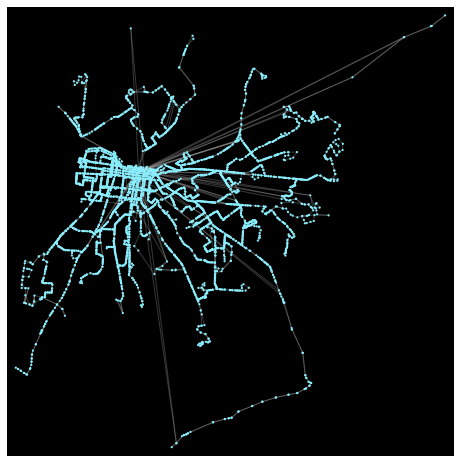

In [12]:
ox.plot_graph(G,
                            figsize=(8,12),
                            show=False,
                            close=False,
                            node_color='#8aedfc',
                            node_size=5,
                            edge_color='#e2dede',
                            edge_alpha=0.25,
                            bgcolor='black')

# Team Code

In [13]:
#checking if they have the same number of nodes and edges
#might loose information from converting MultiDiGraph -> DiGraph

Di_G = nx.DiGraph(G)

print("G type: " + str(type(G)))
print("Di_G type: " + str(type(Di_G)))
print()
print("G #edges: " + str(G.number_of_edges()))
print("G #nodes: " + str(G.number_of_nodes()))
print()
print("Di_G #edges: " + str(Di_G.number_of_edges()))
print("Di_G #nodes: " + str(Di_G.number_of_nodes()))

G type: <class 'networkx.classes.multidigraph.MultiDiGraph'>
Di_G type: <class 'networkx.classes.digraph.DiGraph'>

G #edges: 4807
G #nodes: 4391

Di_G #edges: 4807
Di_G #nodes: 4391


/Users/jdm/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jdm/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


(<Figure size 576x864 with 1 Axes>, <AxesSubplot:>)

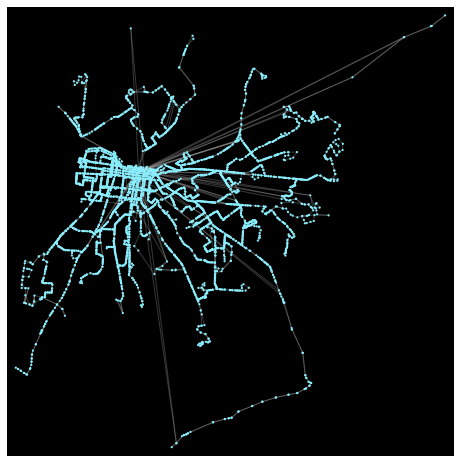

In [14]:
#checking if the graphs are the same graph by
#converting DiGraph -> MultiDiGraph

backto_G = nx.MultiDiGraph(Di_G)

ox.plot_graph(backto_G,
                            figsize=(8,12),
                            show=False,
                            close=False,
                            node_color='#8aedfc',
                            node_size=5,
                            edge_color='#e2dede',
                            edge_alpha=0.25,
                            bgcolor='black')

In [101]:
from typing import List, Optional, Tuple, Union
from torch import Tensor



def from_networkx_modified_depart_times(G, group_node_attrs: Optional[Union[List[str], all]] = None,
                  group_edge_attrs: Optional[Union[List[str], all]] = None):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
        group_node_attrs (List[str] or all, optional): The node attributes to
            be concatenated and added to :obj:`data.x`. (default: :obj:`None`)
        group_edge_attrs (List[str] or all, optional): The edge attributes to
            be concatenated and added to :obj:`data.edge_attr`.
            (default: :obj:`None`)

    .. note::

        All :attr:`group_node_attrs` and :attr:`group_edge_attrs` values must
        be numeric.
        
        MODIFIED FROM ORIGINAL from_networkx() function from pytorch geometric
    """
    
    G = nx.convert_node_labels_to_integers(G)
    G = G.to_directed() if not nx.is_directed(G) else G
    
    if isinstance(G, (nx.MultiGraph, nx.MultiDiGraph)):
        edges = list(G.edges(keys=False))
    else:
        edges = list(G.edges)
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    data = defaultdict(list)
    
    if G.number_of_nodes() > 0:
        node_attrs = list(next(iter(G.nodes(data=True)))[-1].keys())
    else:
        node_attrs = {}
        
    if G.number_of_edges() > 0:
        edge_attrs = list(next(iter(G.edges(data=True)))[-1].keys())
    else:
        edge_attrs = {}
        
    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        if set(feat_dict.keys()) != set(node_attrs):
            raise ValueError('Not all nodes contain the same attributes')
    for key, value in feat_dict.items():
        data[str(key)].append(value)
        
    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        if set(feat_dict.keys()) != set(edge_attrs):
            raise ValueError('Not all edges contain the same attributes')
    for key, value in feat_dict.items():
        key = f'edge_{key}' if key in node_attrs else key
        data[str(key)].append(value)
        
    for key, value in G.graph.items():
        key = f'graph_{key}' if key in node_attrs else key
        data[str(key)] = value
    
    converted_departs = []
    converted_departure_keys = {}
    converted_key_index = 0
    converted_value_length = 0

    for i in data["departure_time"]:
        for key, value in i.items():
            if not converted_departure_keys.get(key):
                converted_departure_keys[key] = converted_key_index
                converted_key_index += 1
            temp = [converted_departure_keys[key]]
            temp.extend(value)
            if len(temp) > converted_value_length:
                converted_value_length = len(temp)
            converted_departs.append(temp)
    
    for lst in converted_departs:
        fill_len = converted_value_length - len(lst)
        fill_lst = [None for _ in range(fill_len)]
        lst.extend(fill_lst)
    
    depart_times_arr = np.array(converted_departs, dtype=np.float32)
    depart_times_tensor = torch.tensor(depart_times_arr)
    
    for key, value in data.items():
        if isinstance(value, (tuple, list)) and isinstance(value[0], Tensor):
            data[key] = torch.stack(value, dim=0)
        else:
            try:
                if key != "departure_time":
                    #name and crs need work - skipped for now
                    if key != "name" and key != "crs":
                        print(key)
                        data[key] = torch.tensor(value)
                else:
                    data[key] = depart_times_tensor
            except ValueError:
                pass
    
    data['edge_index'] = edge_index.view(2, -1)
    data = Data.from_dict(data)

    if group_node_attrs is all:
        group_node_attrs = list(node_attrs)
    if group_node_attrs is not None:
        xs = []
        for key in group_node_attrs:
            x = data[key]
            x = x.view(-1, 1) if x.dim() <= 1 else x
            xs.append(x)
            del data[key]
        data.x = torch.cat(xs, dim=-1)

    if group_edge_attrs is all:
        group_edge_attrs = list(edge_attrs)
    if group_edge_attrs is not None:
        xs = []
        for key in group_edge_attrs:
            key = f'edge_{key}' if key in node_attrs else key
            x = data[key]
            x = x.view(-1, 1) if x.dim() <= 1 else x
            xs.append(x)
            del data[key]
        data.edge_attr = torch.cat(xs, dim=-1)

    if data.x is None and data.pos is None:
        data.num_nodes = G.number_of_nodes()

    return data

In [102]:
data = from_networkx_modified_depart_times(G)

boarding_cost
modes
y
x
length
mode


In [15]:
'''
G_test = nx.convert_node_labels_to_integers(G)
G_test = G_test.to_directed() if not nx.is_directed(G_test) else G_test
edges = list(G_test.edges(keys=False))
print(edges, G_test)
'''

[(0, 1), (1, 2), (2, 2648), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 76), (10, 11), (10, 84), (11, 13), (12, 3585), (13, 14), (14, 2934), (15, 12), (15, 84), (16, 17), (17, 18), (18, 19), (18, 2496), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (41, 42), (42, 43), (43, 44), (44, 45), (45, 175), (46, 47), (47, 48), (48, 49), (49, 50), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55), (54, 450), (55, 56), (56, 57), (57, 58), (58, 59), (59, 60), (60, 61), (61, 62), (62, 63), (63, 64), (64, 69), (64, 65), (65, 66), (66, 67), (67, 68), (68, 85), (69, 4308), (69, 4307), (70, 71), (71, 72), (72, 3153), (73, 74), (74, 75), (75, 78), (76, 10), (77, 79), (78, 2898), (79, 3189), (80, 81), (81, 82), (82, 83), (83, 3158), (84, 12), (84, 11), (85, 86), (86, 87), (87, 69), (88, 90), (88, 4321), (88, 91), (89, 88), (90

In [16]:
'''
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
data = defaultdict(list)
if G_test.number_of_nodes() > 0:
    node_attrs = list(next(iter(G_test.nodes(data=True)))[-1].keys())
else:
    node_attrs = {}
print(edge_index)
print(data)
print(node_attrs)
'''

tensor([[   0,    1,    2,  ..., 4388, 4389, 4390],
        [   1,    2, 2648,  ..., 4390, 1933, 4305]])
defaultdict(<class 'list'>, {})
['boarding_cost', 'modes', 'y', 'x']


In [17]:
'''
if G_test.number_of_edges() > 0:
    edge_attrs = list(next(iter(G_test.edges(data=True)))[-1].keys())
else:
    edge_attrs = {}
print(edge_attrs)
'''

['length', 'mode', 'departure_time']


In [18]:
'''
for i, (_, feat_dict) in enumerate(G_test.nodes(data=True)):
    if set(feat_dict.keys()) != set(node_attrs):
        raise ValueError('Not all nodes contain the same attributes')
    for key, value in feat_dict.items():
        data[str(key)].append(value)
'''

In [19]:
'''
for i, (_, _, feat_dict) in enumerate(G_test.edges(data=True)):
    if set(feat_dict.keys()) != set(edge_attrs):
        raise ValueError('Not all edges contain the same attributes')
    for key, value in feat_dict.items():
        key = f'edge_{key}' if key in node_attrs else key
        data[str(key)].append(value)
'''

In [20]:
'''
for key, value in G_test.graph.items():
    key = f'graph_{key}' if key in node_attrs else key
    data[str(key)] = value
'''

In [84]:
'''
dic = [{'19': 17992.0 }] #[17992.0, 21592.0, 25192.0, 49132.0, 53692.0, 59452.0, 63352.0, 82132.0]}
converted_departs = []
converted_departure_keys = {}
converted_key_index = 0
converted_value_length = 0

for i in data["departure_time"]:
    for key, value in i.items():
        if not converted_departure_keys.get(key):
            converted_departure_keys[key] = converted_key_index
            converted_key_index += 1
        temp = [converted_departure_keys[key]]
        temp.extend(value)
        if len(temp) > converted_value_length:
            converted_value_length = len(temp)
        converted_departs.append(temp)
    
#torch.tensor(data["departure_time"])
'''

In [85]:
#print(converted_value_length)

183


In [86]:
'''
for lst in converted_departs:
    fill_len = converted_value_length - len(lst)
    fill_lst = [None for _ in range(fill_len)]
    lst.extend(fill_lst)
'''

In [81]:
'''
for lst in converted_departs:
    if(len(lst) != 182):
        print(len(lst))
        print(lst)
'''

183
[46, 24509.0, 25109.0, 25769.0, 26189.0, 26429.0, 26729.0, 26969.0, 27209.0, 27509.0, 27749.0, 28049.0, 28289.0, 28529.0, 28829.0, 29069.0, 29369.0, 29609.0, 29849.0, 30149.0, 30389.0, 30689.0, 30929.0, 31169.0, 31469.0, 31709.0, 32009.0, 32249.0, 32489.0, 32789.0, 33029.0, 33329.0, 33569.0, 33809.0, 34109.0, 34349.0, 34649.0, 34889.0, 35129.0, 35429.0, 35669.0, 35969.0, 36209.0, 36449.0, 36749.0, 36989.0, 37289.0, 37529.0, 37769.0, 38069.0, 38309.0, 38609.0, 38849.0, 39089.0, 39389.0, 39629.0, 39929.0, 40169.0, 40409.0, 40709.0, 40949.0, 41249.0, 41489.0, 41729.0, 42029.0, 42269.0, 42569.0, 42809.0, 43049.0, 43349.0, 43589.0, 43889.0, 44129.0, 44369.0, 44669.0, 44909.0, 45209.0, 45449.0, 45689.0, 45989.0, 46229.0, 46529.0, 46769.0, 47009.0, 47309.0, 47549.0, 47849.0, 48089.0, 48329.0, 48629.0, 48869.0, 49169.0, 49409.0, 49649.0, 49949.0, 50189.0, 50489.0, 50729.0, 50969.0, 51149.0, 51329.0, 51509.0, 51809.0, 52049.0, 52289.0, 52469.0, 52649.0, 52829.0, 53129.0, 53369.0, 53609.0, 5

In [69]:
#type(converted_departs)

list

In [88]:
#bruh = np.array(converted_departs, dtype=np.float32)

In [78]:
#test = [[3, 1.0], [2.0, None], [2.0, 3]]
#np.array(test, dtype=np.float32)

array([[ 3.,  1.],
       [ 2., nan],
       [ 2.,  3.]], dtype=float32)

In [89]:
#torch.tensor(bruh)

tensor([[0.0000e+00, 1.7992e+04, 2.1592e+04,  ...,        nan,        nan,
                nan],
        [1.0000e+00, 1.9707e+04, 2.3307e+04,  ...,        nan,        nan,
                nan],
        [2.0000e+00, 1.9978e+04, 2.1538e+04,  ...,        nan,        nan,
                nan],
        ...,
        [8.0000e+00, 2.0220e+04,        nan,  ...,        nan,        nan,
                nan],
        [8.0000e+00, 1.8707e+04, 7.9964e+04,  ...,        nan,        nan,
                nan],
        [8.0000e+00, 2.0230e+04,        nan,  ...,        nan,        nan,
                nan]])

In [52]:
#torch.tensor(converted_departs)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [60]:
#print(converted_departure_keys)
#print(converted_departs)

{'19': 3, '20': 1, '63': 2, '82': 4, '22': 5, '71': 6, '27': 7, '99': 8, '23': 9, '25': 10, '02': 11, '93': 12, '29': 13, '18': 14, '62': 15, '12': 16, '43': 17, '01': 18, '49X': 19, '53X': 20, '61X': 21, '64X': 22, '66X': 23, '78X': 24, '21': 25, '52': 26, '68X': 27, '06': 28, '04': 29, '31': 30, '31X': 31, '45X': 32, '50X': 33, '54X': 34, '67X': 35, '15': 36, '77': 37, '72': 38, '65X': 39, '17': 40, '40': 41, '40X': 42, '17X': 43, '96': 44, '75': 45, '94': 46}
[list([0, 17992.0, 21592.0, 25192.0, 49132.0, 53692.0, 59452.0, 63352.0, 82132.0, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, N

In [56]:
#testArray = np.array([[0.1, 0.2], [0.3, None]], dtype=np.float32)
#torch.tensor(testArray)

tensor([[0.1000, 0.2000],
        [0.3000,    nan]])

In [76]:
#print(converted_departs[0])
#test = np.array([[19, 17992.0, 21592.0, 25192.0, 49132.0, 53692.0, 59452.0, 63352.0, 82132.0], [20, 17992.0, 21592.0, 25192.0, 49132.0, 53692.0, 59452.0, 63352.0, None]])
#torch.tensor(test)

['19'
 list([17992.0, 21592.0, 25192.0, 49132.0, 53692.0, 59452.0, 63352.0, 82132.0])]


In [60]:

'''
from torch import Tensor

for key, value in data.items():
    if isinstance(value, (tuple, list)) and isinstance(value[0], Tensor):
        data[key] = torch.stack(value, dim=0)
    else:
        try:
            #print(type(value))
            #print(value)
            print(key)
            data[key] = torch.tensor(value)
        except ValueError:
            pass
'''

boarding_cost
modes
y
x
length
mode
departure_time


/var/folders/zd/wvyphw2555s5vqr7rc1mkcj80000gn/T/ipykernel_40465/3889112082.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data[key] = torch.tensor(value)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
#matrix_bruh = nx.to_scipy_sparse_matrix(Di_G)
#type(matrix_bruh)

In [ ]:
#df_mat = pd.DataFrame.sparse.from_spmatrix(matrix_bruh)
#df_mat

In [ ]:
#dictionary = df_mat.to_dict()

In [ ]:
#type(dictionary.keys())

In [ ]:
#new_dic = {}
#for key in dictionary:
#    new_dic[str(key)] = dictionary[key]


In [ ]:
#pyG_data1 = Data.from_dict(new_dic)

In [ ]:
#type(pyG_data1)

In [ ]:
#data = pyg.from_scipy_sparse_matrix(matrix_bruh)
#type(data)

In [179]:
from collections import defaultdict, OrderedDict, Counter
#import networkx as nx
#import numpy as np
#import peartree as pt
import random
import sys
import torch.nn.functional as F
from torch_geometric.nn import GeneralConv
import pandas as pd

In [180]:
class GeneralConvMod(torch.nn.Module):
    def __init__(self):
        super().__init__()
        """ GeneralConv layers """
        self.conv1 = GeneralConv(data.num_features, 16)
        self.conv2 = GeneralConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return self.lin(x)

In [182]:
device = torch.device('cpu')
model = GeneralConvMod().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [183]:
print(model)

GeneralConvMod(
  (conv1): GeneralConv(1, 16)
  (conv2): GeneralConv(16, 1)
)


In [122]:
for network in sim.network_file_list:
    print("starting simulation for " + network)
    reset_network()
    sim.network_file = network

    load_network()
    load_stop_times()
    format_stop_times()
    analyze_stops()
    get_departure_times_per_edge_per_route()
    add_departure_to_edge()
    generate_route_subgraphs()
    
    for seed in range(0, sim.no_of_seeds):
        reset_sim()

        sim.seed = seed
        np.random.seed(sim.seed)
        random.seed(sim.seed)

        randomly_select_sensor_locations()
        assign_sensors_to_nodes()
        generate_sensors()
        if network == 'louisville.zip':
            for algo in ["celf", "in_degree", "betweenness"]:
                for index in range(len(sim.louisville_gateways["celf"])):
                    generate_sensors()
                    load_gateways(sim.louisville_gateways[algo][:index + 1])
                    print_stats()
                    generate_route_subgraphs()
                    run_simulation()
                    t = store_results(algo + "_budget" + str(index + 1))
        elif network == 'cht.zip':
            for algo in ["celf", "in_degree", "betweenness"]:
                for index in range(len(sim.cht_gateways["celf"])):
                    generate_sensors()
                    load_gateways(sim.cht_gateways[algo][:index + 1])
                    print_stats()
                    generate_route_subgraphs()
                    run_simulation()
                    t = store_results(algo + "_budget" + str(index + 1))
        else:
            print("I don't know the city's gateways from sim.py, pele. I must quit!!!")
            sys.exit()

None
